# Tensorflow Object Detection Inference


In [2]:
!pip install -U --pre tensorflow=="2.2.0"

     |████████████████████████████████| 516.2MB 31kB/s 
     |████████████████████████████████| 460kB 33.8MB/s 
     |████████████████████████████████| 3.0MB 34.8MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


## Install Object Detection API

In [4]:
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2444, done.
remote: Counting objects: 100% (2444/2444), done.
remote: Compressing objects: 100% (2049/2049), done.
remote: Total 2444 (delta 582), reused 1382 (delta 367), pack-reused 0
Receiving objects: 100% (2444/2444), 30.85 MiB | 22.35 MiB/s, done.
Resolving deltas: 100% (582/582), done.


In [5]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1624271 sha256=c2fa260907a35967eaac352cd42b3d4711010ebb8336824894ff32509b2bf7e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-hvg4cof9/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.1-cp37-none-any.whl size=43735 sha256=41d7e9d4a7d5d96ce2f6a31f184a3f355359fdc2fb6d57a09392ab5813d6a886
  Stored in directory: /root/.cache/pip/wheels/65/fe/90/20d6d6d97223d80d20cb390be636619c536edab5658c12bdba
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78532 sha256=adfaf57482afd964718e07c6a4547534d205e3b9fbdb56d83c7e7d8ff376559c
  Stored in directory: /root/.cache/pip/wheels/59/b1/91/f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=dbcfe62b0859c8e8b90092b638c2b7c5470839efb35af716215d

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.28.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.1 which is incompatible.


## Imports and setup

In [40]:
import os
import io
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import time

import tensorflow as tf

from object_detection.utils import label_map_util, config_util
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline
# import warnings
# warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

## Connect with drive

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load model

In [11]:
ROOT = 'gdrive/MyDrive/MIA2/landmark_detections'
PATH_TO_SAVED_MODEL = os.path.join(ROOT, 'models', 'saved_model')
PATH_TO_LABELS = os.path.join(ROOT, 'landmarks_label_map.pbtxt')

print('Model path {}'.format(PATH_TO_SAVED_MODEL))
print('Label path {}'.format(PATH_TO_LABELS))

Model path gdrive/MyDrive/MIA2/landmark_detections/models/saved_model
Label path gdrive/MyDrive/MIA2/landmark_detections/landmarks_label_map.pbtxt


In [12]:
# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
print('Model loaded')

Model loaded


## Load label map

In [36]:
category_index = label_map_util.create_categories_from_labelmap(PATH_TO_LABELS)
category_index

[{'id': 1, 'name': 'mark'}]

## Run detections

In [15]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  return np.array(Image.open(path))

In [16]:
IMAGES_FOLDER = os.path.join(ROOT, 'data')
images_list = os.listdir(IMAGES_FOLDER)
print('Images folder {}'.format(IMAGES_FOLDER))

Images folder gdrive/MyDrive/MIA2/landmark_detections/data


1/14. Running inference for img_150.jpg


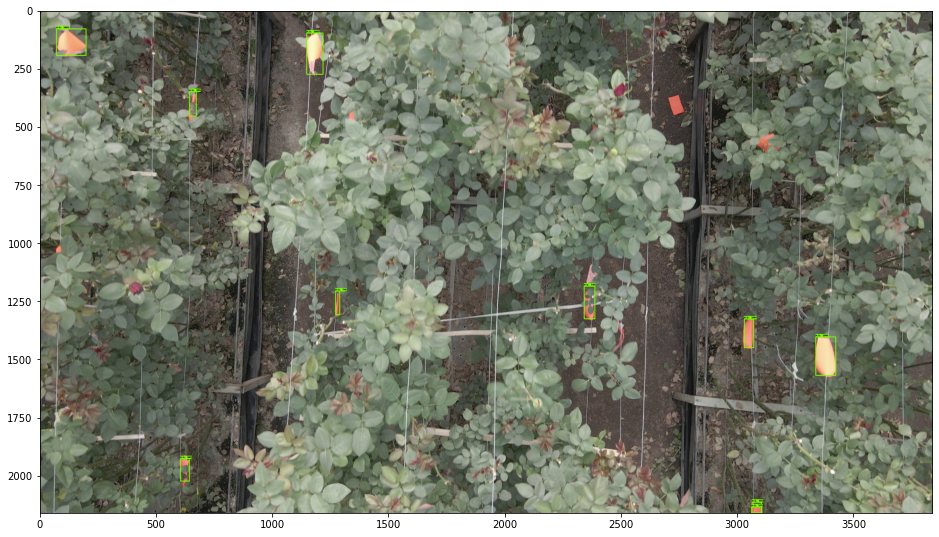

In [46]:
for idx, image_name in enumerate(images_list):
  print('{}/{}. Running inference for {}'.format(idx + 1, len(images_list), image_name))
  image_np = load_image_into_numpy_array(os.path.join(IMAGES_FOLDER, image_name))
  input_tensor = tf.convert_to_tensor(image_np)
  input_tensor = input_tensor[tf.newaxis, ...]

  # run detections
  detections = detect_fn(input_tensor)

  num_detections = int(detections.pop('num_detections'))

  detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
  detections['num_detections'] = num_detections
  
  # detection_classes should be ints
  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

  image_np_with_detections = image_np.copy()
  label_id_offset = 1
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index[0],
      use_normalized_coordinates=True,
      max_boxes_to_draw=20,
      min_score_thresh=.50,
      agnostic_mode=False)
  plt.figure(figsize=(16, 20))
  plt.imshow(image_np_with_detections)
  # analyze only one image
  break
plt.show()